In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torchvision.datasets as datasets

In [17]:
# Loading the data 
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))


Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


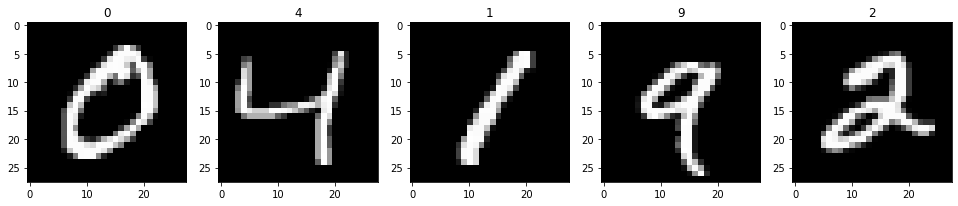

In [18]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
import torch

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [0]:
net = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

if (torch.cuda.is_available()):
    net.cuda()


Epoch: 1/20, Train Loss: 0.29404398, Val Loss: 0.05810123, Val Accuracy: 0.98188889
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05810123

Epoch: 2/20, Train Loss: 0.10090534, Val Loss: 0.03640694, Val Accuracy: 0.98800000
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03640694

Epoch: 3/20, Train Loss: 0.07591840, Val Loss: 0.03225933, Val Accuracy: 0.99000000
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03225933

Epoch: 4/20, Train Loss: 0.06166339, Val Loss: 0.02637954, Val Accuracy: 0.99155556
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02637954

Epoch: 5/20, Train Loss: 0.05214782, Val Loss: 0.02526403, Val Accuracy: 0.99177778
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02526403

Epoch: 6/20, Train Loss: 0.04769453, Val Loss: 0.02400927, Val Accuracy: 0.99166667
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02400927

Epoch: 7/

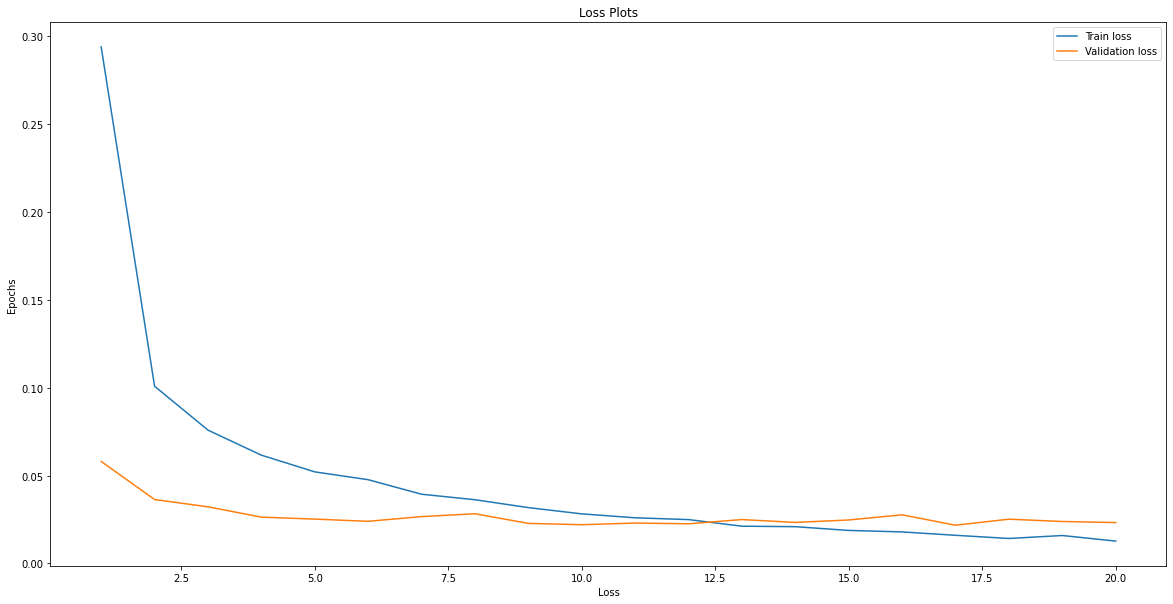

In [21]:
no_epochs = 20
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    net.train()
    # training
    for iter, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = net(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (iter + 1)
    train_loss.append(total_train_loss)

    # validation
    net.eval()
    total = 0
    for iter, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = net(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (iter + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(net.state_dict(), "net.dth")

# fig=plt.figure(figsize=(20, 10))
# plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
# plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
# plt.xlabel('Loss')
# plt.ylabel('Epochs')
# plt.title("Loss Plots")
# plt.legend(loc='upper right')
# plt.show()
